In [3]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import ast

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("husl")

In [4]:
def extract_tasks_from_file(file_path):
    """Extract task information from LLaDA output file."""
    
    tasks = []
    
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Regular expressions for parsing
    task_pattern = r'Task ID: ([a-f0-9]+)'
    correct_shape_pattern = r'Correct Output Shape: (\d+x\d+|Could not extract grid)'
    generated_shape_pattern = r'Generated Output Shape: (\d+x\d+|Could not extract grid)'
    accuracy_pattern = r'ACCURACY: ([\d.]+)%'
    
    # Find all task blocks
    task_blocks = content.split('================================================================================')
    
    for block in task_blocks:
        if 'Task ID:' in block:
            task_info = {}
            
            # Extract task ID
            task_match = re.search(task_pattern, block)
            if task_match:
                task_info['task_id'] = task_match.group(1)
            
            # Extract correct shape
            correct_shape_match = re.search(correct_shape_pattern, block)
            if correct_shape_match:
                shape_str = correct_shape_match.group(1)
                if shape_str != 'Could not extract grid':
                    dims = shape_str.split('x')
                    task_info['correct_shape'] = (int(dims[0]), int(dims[1]))
                    task_info['correct_size'] = int(dims[0]) * int(dims[1])
                else:
                    task_info['correct_shape'] = None
                    task_info['correct_size'] = None
            
            # Extract generated shape
            generated_shape_match = re.search(generated_shape_pattern, block)
            if generated_shape_match:
                shape_str = generated_shape_match.group(1)
                if shape_str != 'Could not extract grid':
                    dims = shape_str.split('x')
                    task_info['generated_shape'] = (int(dims[0]), int(dims[1]))
                    task_info['generated_size'] = int(dims[0]) * int(dims[1])
                else:
                    task_info['generated_shape'] = None
                    task_info['generated_size'] = None
            
            # Extract accuracy
            accuracy_match = re.search(accuracy_pattern, block)
            if accuracy_match:
                task_info['accuracy'] = float(accuracy_match.group(1))
            else:
                task_info['accuracy'] = 0.0
            
            # Check if task failed (ERROR)
            task_info['failed'] = 'ERROR' in block
            
            # Extract error type if failed
            if task_info['failed']:
                if 'CUDA out of memory' in block:
                    task_info['error_type'] = 'CUDA OOM'
                else:
                    task_info['error_type'] = 'Other'
            else:
                task_info['error_type'] = None
            
            # Extract grids if available
            correct_grid_pattern = r'Correct Output:\n((?:[0-9 ]+\n?)+)'
            generated_grid_pattern = r'Generated Grid:\n((?:[0-9 ]+\n?)+|Empty grid)'
            
            correct_grid_match = re.search(correct_grid_pattern, block)
            if correct_grid_match:
                grid_text = correct_grid_match.group(1).strip()
                task_info['correct_grid'] = grid_text
            
            generated_grid_match = re.search(generated_grid_pattern, block)
            if generated_grid_match:
                grid_text = generated_grid_match.group(1).strip()
                task_info['generated_grid'] = grid_text
            
            tasks.append(task_info)
    
    return tasks

def parse_summary_stats(file_path):
    """Extract summary statistics from the file."""
    
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Try to find the JSON summary
    json_pattern = r'Summary:\s*({[^{}]*(?:{[^{}]*}[^{}]*)*})'
    json_match = re.search(json_pattern, content)
    
    if json_match:
        try:
            summary_text = json_match.group(1)
            summary = json.loads(summary_text)
            return summary
        except json.JSONDecodeError:
            pass
    
    # If JSON parsing fails, try to extract statistics directly from the final summary section
    summary = {}
    
    # Extract total tasks
    total_tasks_pattern = r'Total tasks:\s*(\d+)'
    total_tasks_match = re.search(total_tasks_pattern, content)
    if total_tasks_match:
        summary['total_tasks'] = int(total_tasks_match.group(1))
    
    # Extract successful tasks
    successful_tasks_pattern = r'Successful tasks:\s*(\d+)'
    successful_tasks_match = re.search(successful_tasks_pattern, content)
    if successful_tasks_match:
        summary['successful_tasks'] = int(successful_tasks_match.group(1))
    
    # Extract failed tasks
    failed_tasks_pattern = r'Failed tasks:\s*(\d+)'
    failed_tasks_match = re.search(failed_tasks_pattern, content)
    if failed_tasks_match:
        summary['failed_tasks'] = int(failed_tasks_match.group(1))
    
    # Extract average accuracy
    average_accuracy_pattern = r'Average accuracy:\s*([\d.]+)%'
    average_accuracy_match = re.search(average_accuracy_pattern, content)
    if average_accuracy_match:
        summary['average_accuracy'] = float(average_accuracy_match.group(1))
    
    # Extract perfect accuracy tasks
    perfect_accuracy_pattern = r'Perfect accuracy tasks:\s*(\d+)'
    perfect_accuracy_match = re.search(perfect_accuracy_pattern, content)
    if perfect_accuracy_match:
        summary['perfect_accuracy_tasks'] = int(perfect_accuracy_match.group(1))
    
    # If we found at least some statistics, return the summary
    if summary:
        return summary
    
    # If all else fails, create a minimal summary from the tasks in the file
    print(f"Warning: Could not extract summary statistics from {file_path}. Creating minimal summary from tasks.")
    tasks = extract_tasks_from_file(file_path)
    
    if tasks:
        successful_tasks = [t for t in tasks if not t.get('failed', False)]
        summary = {
            'total_tasks': len(tasks),
            'successful_tasks': len(successful_tasks),
            'failed_tasks': len(tasks) - len(successful_tasks),
            'average_accuracy': sum(t.get('accuracy', 0) for t in successful_tasks) / len(successful_tasks) if successful_tasks else 0,
            'perfect_accuracy_tasks': sum(1 for t in tasks if t.get('accuracy', 0) == 100.0)
        }
        return summary
    
    return {
        'total_tasks': 'N/A',
        'successful_tasks': 'N/A',
        'failed_tasks': 'N/A',
        'average_accuracy': 'N/A',
        'perfect_accuracy_tasks': 'N/A'
    }

def load_all_results(file_paths):
    """Load results from multiple files and combine them."""
    
    all_tasks = []
    all_summaries = {}
    
    for file_path in file_paths:
        file_name = Path(file_path).name
        tasks = extract_tasks_from_file(file_path)
        summary = parse_summary_stats(file_path)
        
        # Add file source to each task
        for task in tasks:
            task['source_file'] = file_name
        
        all_tasks.extend(tasks)
        all_summaries[file_name] = summary
    
    return pd.DataFrame(all_tasks), all_summaries

In [5]:
# File paths
file_paths = [
    '/scratch/sz4972/DiCoRGI/llada/llada_parallel.out',
    '/scratch/sz4972/DiCoRGI/llada/llada_resume.out'
]

# Load data
df, summaries = load_all_results(file_paths)

print(f"Total tasks loaded: {len(df)}")
print(f"Files processed: {list(summaries.keys())}")
print("\nSummary per file:")
for file_name, summary in summaries.items():
    print(f"\n{file_name}:")
    print(f"  Total tasks: {summary.get('total_tasks', 'N/A')}")
    print(f"  Average accuracy: {summary.get('average_accuracy', 'N/A'):.2f}%")
    print(f"  Failed tasks: {summary.get('failed_tasks', 'N/A')}")

Total tasks loaded: 372
Files processed: ['llada_parallel.out', 'llada_resume.out']

Summary per file:

llada_parallel.out:
  Total tasks: 256
  Average accuracy: 9.05%
  Failed tasks: 0

llada_resume.out:
  Total tasks: 144
  Average accuracy: 9.53%
  Failed tasks: 4


In [7]:
# Basic statistics
print("Dataset Overview:")
print(f"Total tasks: {len(df)}")
print(f"Successful tasks: {len(df[~df['failed']])}")
print(f"Failed tasks: {len(df[df['failed']])}")
print(f"Perfect accuracy (100%): {len(df[df['accuracy'] == 100.0])}")
print(f"Zero accuracy (0%): {len(df[df['accuracy'] == 0.0])}")
print(f"Average accuracy (successful tasks): {df[~df['failed']]['accuracy'].mean():.2f}%")

# Distribution by source file
print("\nDistribution by source file:")
for file_name in df['source_file'].unique():
    file_df = df[df['source_file'] == file_name]
    print(f"{file_name}: {len(file_df)} tasks")

# Show tasks with 100% accuracy
perfect_tasks = df[df['accuracy'] == 100.0]
if len(perfect_tasks) > 0:
    print("\nTasks with 100% accuracy:")
    for idx, task in perfect_tasks.iterrows():
        print(f"  Task ID: {task['task_id']} | Source: {task['source_file']}")
        if 'correct_shape' in task and task['correct_shape'] is not None:
            print(f"  Shape: {task['correct_shape']}")
        print()
else:
    print("\nNo tasks achieved 100% accuracy.")

Dataset Overview:
Total tasks: 372
Successful tasks: 372
Failed tasks: 0
Perfect accuracy (100%): 11
Zero accuracy (0%): 327
Average accuracy (successful tasks): 9.11%

Distribution by source file:
llada_parallel.out: 256 tasks
llada_resume.out: 116 tasks

Tasks with 100% accuracy:
  Task ID: 25d8a9c8 | Source: llada_parallel.out
  Shape: (3, 3)

  Task ID: 25ff71a9 | Source: llada_parallel.out
  Shape: (3, 3)

  Task ID: 4c4377d9 | Source: llada_parallel.out
  Shape: (6, 4)

  Task ID: 5582e5ca | Source: llada_parallel.out
  Shape: (3, 3)

  Task ID: 67385a82 | Source: llada_parallel.out
  Shape: (5, 5)

  Task ID: 6d0aefbc | Source: llada_parallel.out
  Shape: (3, 6)

  Task ID: 6fa7a44f | Source: llada_parallel.out
  Shape: (6, 3)

  Task ID: 8be77c9e | Source: llada_parallel.out
  Shape: (6, 3)

  Task ID: bc1d5164 | Source: llada_parallel.out
  Shape: (3, 3)

  Task ID: bc1d5164 | Source: llada_resume.out
  Shape: (3, 3)

  Task ID: e3497940 | Source: llada_resume.out
  Shape: (10

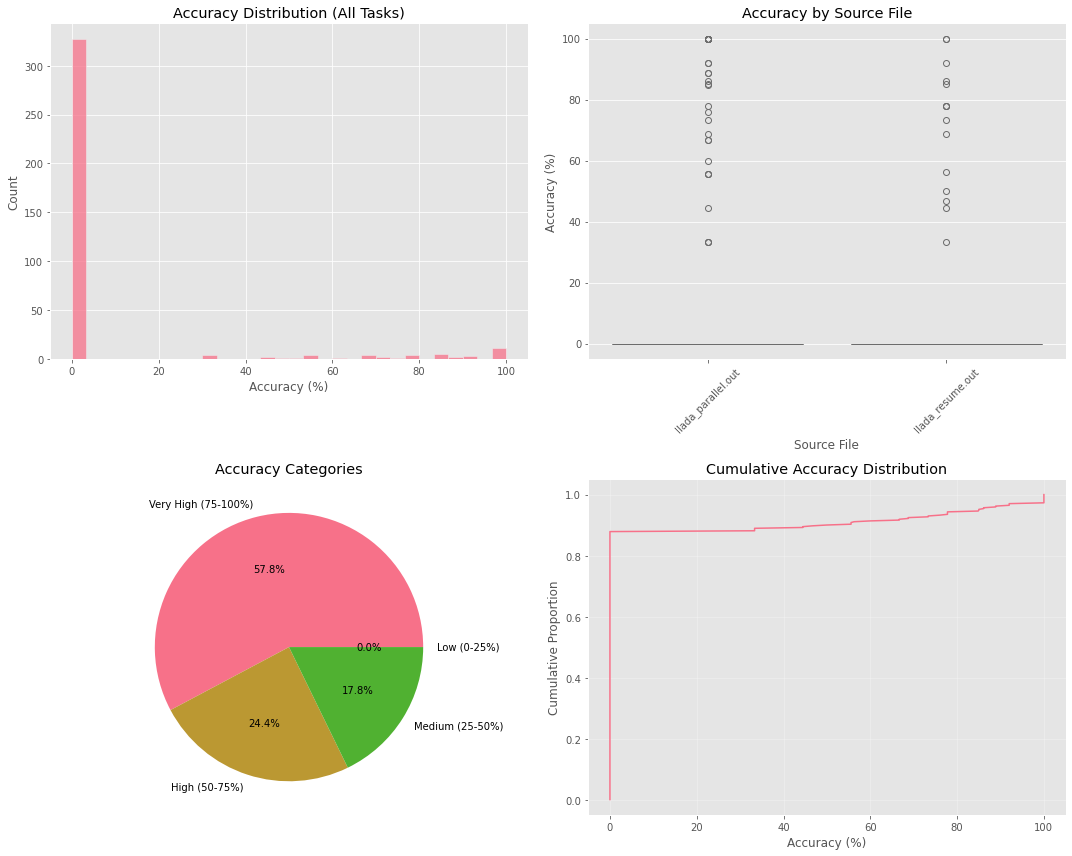

In [11]:
# Accuracy distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Overall accuracy distribution
sns.histplot(data=df[~df['failed']], x='accuracy', bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Accuracy Distribution (All Tasks)')
axes[0, 0].set_xlabel('Accuracy (%)')
axes[0, 0].set_ylabel('Count')

# Accuracy distribution by file
sns.boxplot(data=df[~df['failed']], x='source_file', y='accuracy', ax=axes[0, 1])
axes[0, 1].set_title('Accuracy by Source File')
axes[0, 1].set_xlabel('Source File')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Accuracy categories
accuracy_categories = pd.cut(df[~df['failed']]['accuracy'], 
                           bins=[0, 25, 50, 75, 100], 
                           labels=['Low (0-25%)', 'Medium (25-50%)', 'High (50-75%)', 'Very High (75-100%)'])
category_counts = accuracy_categories.value_counts()
axes[1, 0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
axes[1, 0].set_title('Accuracy Categories')

# Cumulative accuracy distribution
sorted_accuracies = df[~df['failed']]['accuracy'].sort_values()
cumulative = np.arange(1, len(sorted_accuracies) + 1) / len(sorted_accuracies)
axes[1, 1].plot(sorted_accuracies, cumulative)
axes[1, 1].set_xlabel('Accuracy (%)')
axes[1, 1].set_ylabel('Cumulative Proportion')
axes[1, 1].set_title('Cumulative Accuracy Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

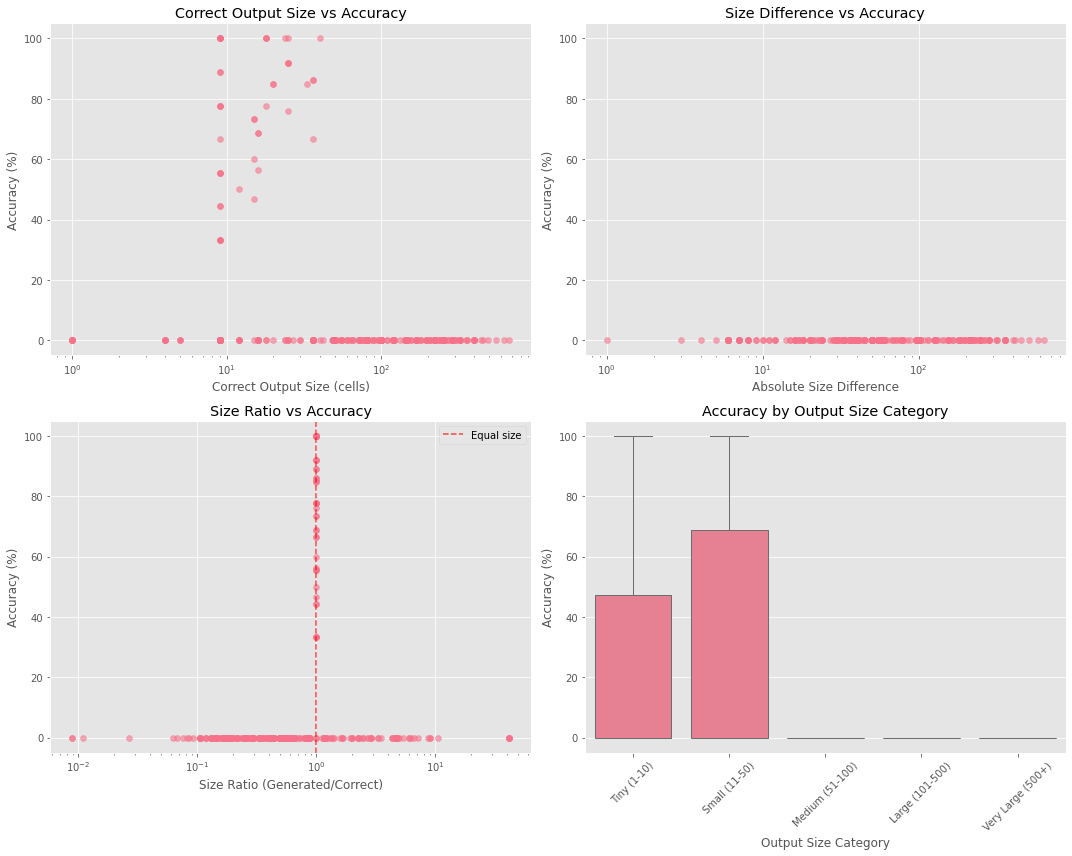

Size Statistics:
Average correct size: 111.52
Median correct size: 90.00
Average generated size: 38.04
Median generated size: 42.00


In [12]:
# Task size analysis
df_valid = df[(~df['failed']) & (df['correct_size'].notna()) & (df['generated_size'].notna())].copy()

# Size relationship with accuracy
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Correct size vs accuracy
axes[0, 0].scatter(df_valid['correct_size'], df_valid['accuracy'], alpha=0.6)
axes[0, 0].set_xlabel('Correct Output Size (cells)')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_title('Correct Output Size vs Accuracy')
axes[0, 0].set_xscale('log')

# Size difference vs accuracy
df_valid['size_diff'] = abs(df_valid['correct_size'] - df_valid['generated_size'])
axes[0, 1].scatter(df_valid['size_diff'], df_valid['accuracy'], alpha=0.6)
axes[0, 1].set_xlabel('Absolute Size Difference')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Size Difference vs Accuracy')
axes[0, 1].set_xscale('log')

# Size ratio vs accuracy
df_valid['size_ratio'] = df_valid['generated_size'] / df_valid['correct_size']
df_valid['size_ratio'] = df_valid['size_ratio'].replace([np.inf, -np.inf], np.nan)
df_valid_ratio = df_valid[df_valid['size_ratio'].notna()]

axes[1, 0].scatter(df_valid_ratio['size_ratio'], df_valid_ratio['accuracy'], alpha=0.6)
axes[1, 0].set_xlabel('Size Ratio (Generated/Correct)')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Size Ratio vs Accuracy')
axes[1, 0].set_xscale('log')
axes[1, 0].axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='Equal size')
axes[1, 0].legend()

# Size categories vs accuracy
df_valid['size_category'] = pd.cut(df_valid['correct_size'], 
                                 bins=[0, 10, 50, 100, 500, np.inf],
                                 labels=['Tiny (1-10)', 'Small (11-50)', 'Medium (51-100)', 'Large (101-500)', 'Very Large (500+)'])

sns.boxplot(data=df_valid, x='size_category', y='accuracy', ax=axes[1, 1])
axes[1, 1].set_xlabel('Output Size Category')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Accuracy by Output Size Category')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Size statistics
print("Size Statistics:")
print(f"Average correct size: {df_valid['correct_size'].mean():.2f}")
print(f"Median correct size: {df_valid['correct_size'].median():.2f}")
print(f"Average generated size: {df_valid['generated_size'].mean():.2f}")
print(f"Median generated size: {df_valid['generated_size'].median():.2f}")

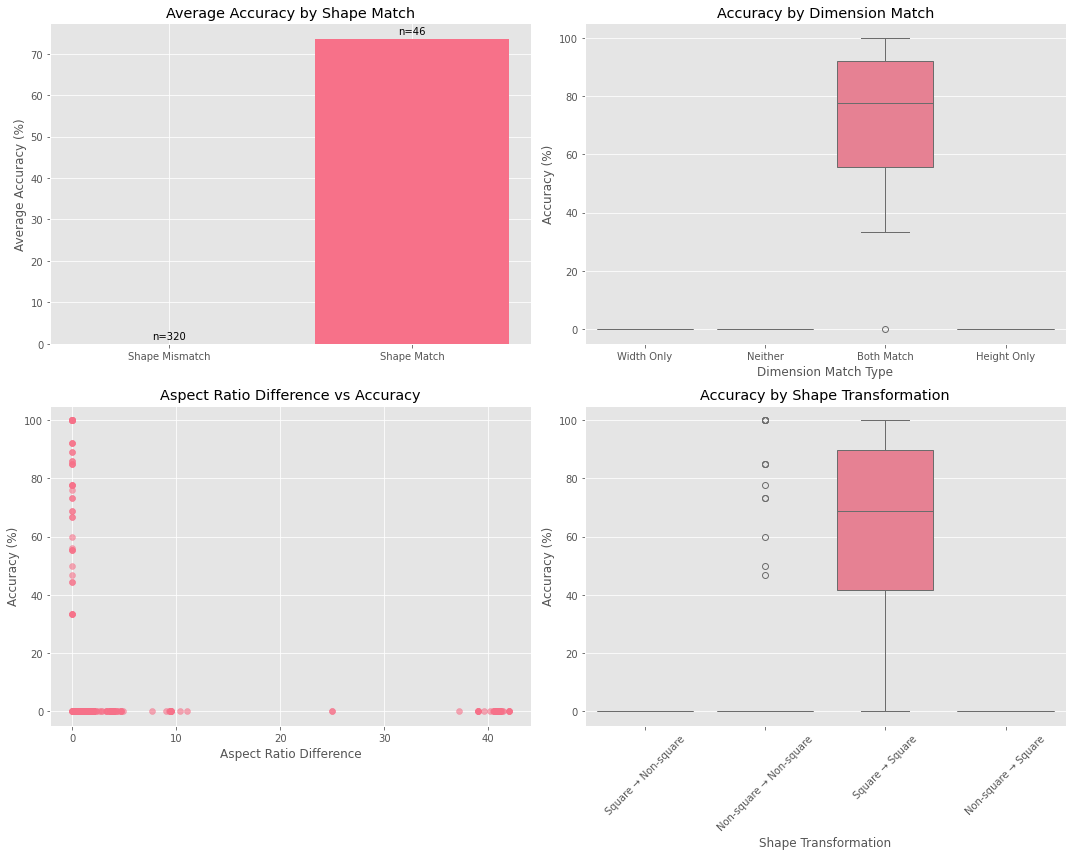

Shape Analysis Statistics:
Tasks with shape match: 46 (12.6%)
Tasks with height match: 69 (18.9%)
Tasks with width match: 159 (43.4%)
Average accuracy when shape matches: 73.6%
Average accuracy when shape doesn't match: 0.0%


In [16]:
# Shape analysis - make sure to create shape_match column first
def ensure_shape_match_column(df):
    """Ensure the shape_match column exists in the DataFrame."""
    if 'shape_match' not in df.columns and 'correct_shape' in df.columns and 'generated_shape' in df.columns:
        # Need to handle NaN values in shapes
        df['shape_match'] = False  # Default to False
        mask = df['correct_shape'].notna() & df['generated_shape'].notna()
        df.loc[mask, 'shape_match'] = df.loc[mask, 'correct_shape'] == df.loc[mask, 'generated_shape']
    elif 'shape_match' not in df.columns:
        df['shape_match'] = False  # Add dummy column if shapes aren't available
    return df

# Ensure shape_match column exists
df = ensure_shape_match_column(df)

# Shape analysis
df_shape = df[(~df['failed']) & (df['correct_shape'].notna()) & (df['generated_shape'].notna())].copy()

# Extract dimensions - handle potential tuples or other formats
def extract_height_width(shape):
    """Extract height and width from shape, handling various formats."""
    if isinstance(shape, tuple) and len(shape) == 2:
        return shape[0], shape[1]
    elif isinstance(shape, str) and 'x' in shape:
        parts = shape.split('x')
        if len(parts) == 2:
            try:
                return int(parts[0]), int(parts[1])
            except ValueError:
                pass
    return None, None

df_shape['correct_height'] = df_shape['correct_shape'].apply(lambda x: extract_height_width(x)[0])
df_shape['correct_width'] = df_shape['correct_shape'].apply(lambda x: extract_height_width(x)[1])
df_shape['generated_height'] = df_shape['generated_shape'].apply(lambda x: extract_height_width(x)[0])
df_shape['generated_width'] = df_shape['generated_shape'].apply(lambda x: extract_height_width(x)[1])

# Only analyze rows where we have valid dimensions
df_shape = df_shape[df_shape['correct_height'].notna() & 
                    df_shape['correct_width'].notna() & 
                    df_shape['generated_height'].notna() & 
                    df_shape['generated_width'].notna()].copy()

if len(df_shape) > 0:
    # Shape match analysis
    df_shape['height_match'] = df_shape['correct_height'] == df_shape['generated_height']
    df_shape['width_match'] = df_shape['correct_width'] == df_shape['generated_width']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Shape match vs accuracy
    shape_match_acc = df_shape.groupby('shape_match')['accuracy'].agg(['mean', 'count'])
    if len(shape_match_acc) > 0:
        axes[0, 0].bar(['Shape Mismatch', 'Shape Match'], shape_match_acc['mean'])
        axes[0, 0].set_ylabel('Average Accuracy (%)')
        axes[0, 0].set_title('Average Accuracy by Shape Match')
        # Add count labels
        for i, (count, mean) in enumerate(zip(shape_match_acc['count'], shape_match_acc['mean'])):
            axes[0, 0].text(i, mean + 1, f'n={count}', ha='center')

    # Dimension match analysis
    dim_data = []
    for idx, row in df_shape.iterrows():
        if row['height_match'] and row['width_match']:
            dim_data.append(('Both Match', row['accuracy']))
        elif row['height_match']:
            dim_data.append(('Height Only', row['accuracy']))
        elif row['width_match']:
            dim_data.append(('Width Only', row['accuracy']))
        else:
            dim_data.append(('Neither', row['accuracy']))

    dim_df = pd.DataFrame(dim_data, columns=['match_type', 'accuracy'])
    if len(dim_df) > 0:
        sns.boxplot(data=dim_df, x='match_type', y='accuracy', ax=axes[0, 1])
        axes[0, 1].set_xlabel('Dimension Match Type')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].set_title('Accuracy by Dimension Match')

    # Aspect ratio analysis - only if we have enough data
    if len(df_shape) > 5:
        df_shape['correct_aspect'] = df_shape['correct_width'] / df_shape['correct_height']
        df_shape['generated_aspect'] = df_shape['generated_width'] / df_shape['generated_height']
        df_shape['aspect_diff'] = abs(df_shape['correct_aspect'] - df_shape['generated_aspect'])

        # Handle infinite or NaN values
        df_shape_filtered = df_shape[np.isfinite(df_shape['aspect_diff'])]
        if len(df_shape_filtered) > 5:
            axes[1, 0].scatter(df_shape_filtered['aspect_diff'], df_shape_filtered['accuracy'], alpha=0.6)
            axes[1, 0].set_xlabel('Aspect Ratio Difference')
            axes[1, 0].set_ylabel('Accuracy (%)')
            axes[1, 0].set_title('Aspect Ratio Difference vs Accuracy')

    # Square vs non-square analysis
    df_shape['correct_is_square'] = df_shape['correct_height'] == df_shape['correct_width']
    df_shape['generated_is_square'] = df_shape['generated_height'] == df_shape['generated_width']

    square_data = []
    for idx, row in df_shape.iterrows():
        if row['correct_is_square']:
            if row['generated_is_square']:
                square_data.append(('Square → Square', row['accuracy']))
            else:
                square_data.append(('Square → Non-square', row['accuracy']))
        else:
            if row['generated_is_square']:
                square_data.append(('Non-square → Square', row['accuracy']))
            else:
                square_data.append(('Non-square → Non-square', row['accuracy']))

    square_df = pd.DataFrame(square_data, columns=['transformation', 'accuracy'])
    if len(square_df) > 0:
        sns.boxplot(data=square_df, x='transformation', y='accuracy', ax=axes[1, 1])
        axes[1, 1].set_xlabel('Shape Transformation')
        axes[1, 1].set_ylabel('Accuracy (%)')
        axes[1, 1].set_title('Accuracy by Shape Transformation')
        axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Shape statistics
    print("Shape Analysis Statistics:")
    print(f"Tasks with shape match: {df_shape['shape_match'].sum()} ({df_shape['shape_match'].mean() * 100:.1f}%)")
    print(f"Tasks with height match: {df_shape['height_match'].sum()} ({df_shape['height_match'].mean() * 100:.1f}%)")
    print(f"Tasks with width match: {df_shape['width_match'].sum()} ({df_shape['width_match'].mean() * 100:.1f}%)")
    
    shape_match_acc = df_shape.groupby('shape_match')['accuracy'].mean()
    if False in shape_match_acc.index and True in shape_match_acc.index:
        print(f"Average accuracy when shape matches: {shape_match_acc[True]:.1f}%")
        print(f"Average accuracy when shape doesn't match: {shape_match_acc[False]:.1f}%")
else:
    print("No valid shape data available for analysis.")

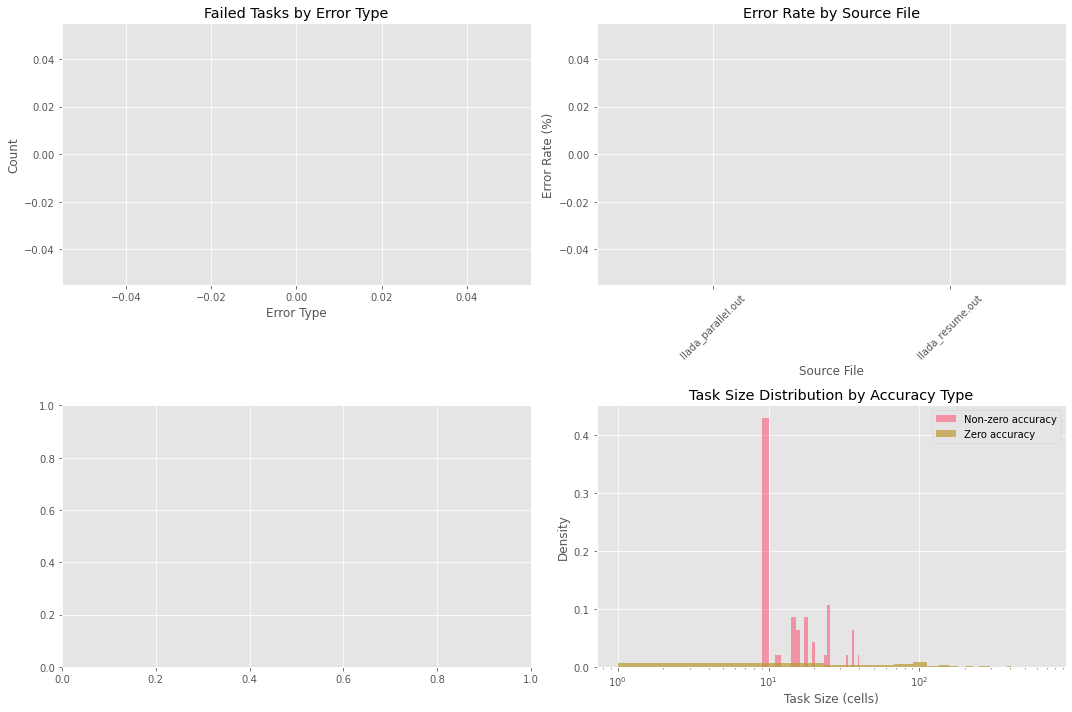

Error Analysis:
Total failed tasks: 0
CUDA OOM errors: 0
Tasks with zero accuracy: 327
Tasks with perfect accuracy: 11


In [17]:
# Error analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Failed tasks by error type
error_counts = df[df['failed']]['error_type'].value_counts()
axes[0, 0].bar(error_counts.index, error_counts.values)
axes[0, 0].set_xlabel('Error Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Failed Tasks by Error Type')

# Error rate by file
error_rates = df.groupby('source_file')['failed'].mean() * 100
axes[0, 1].bar(error_rates.index, error_rates.values)
axes[0, 1].set_xlabel('Source File')
axes[0, 1].set_ylabel('Error Rate (%)')
axes[0, 1].set_title('Error Rate by Source File')
axes[0, 1].tick_params(axis='x', rotation=45)

# Common characteristics of failed tasks
if len(df[df['failed']]) > 0 and 'correct_size' in df.columns:
    failed_sizes = df[df['failed'] & df['correct_size'].notna()]['correct_size']
    success_sizes = df[~df['failed'] & df['correct_size'].notna()]['correct_size']
    
    axes[1, 0].hist(success_sizes, bins=30, alpha=0.7, label='Successful', density=True)
    axes[1, 0].hist(failed_sizes, bins=30, alpha=0.7, label='Failed', density=True)
    axes[1, 0].set_xlabel('Task Size (cells)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Task Size Distribution by Success/Failure')
    axes[1, 0].set_xscale('log')
    axes[1, 0].legend()

# Zero accuracy analysis
zero_acc = df[(df['accuracy'] == 0.0) & (~df['failed'])]
non_zero_acc = df[(df['accuracy'] > 0.0) & (~df['failed'])]

if len(zero_acc) > 0 and len(non_zero_acc) > 0 and 'correct_size' in df.columns:
    axes[1, 1].hist(non_zero_acc['correct_size'].dropna(), bins=30, alpha=0.7, label='Non-zero accuracy', density=True)
    axes[1, 1].hist(zero_acc['correct_size'].dropna(), bins=30, alpha=0.7, label='Zero accuracy', density=True)
    axes[1, 1].set_xlabel('Task Size (cells)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Task Size Distribution by Accuracy Type')
    axes[1, 1].set_xscale('log')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("Error Analysis:")
print(f"Total failed tasks: {len(df[df['failed']])}")
print(f"CUDA OOM errors: {len(df[df['error_type'] == 'CUDA OOM'])}")
print(f"Tasks with zero accuracy: {len(df[df['accuracy'] == 0.0])}")
print(f"Tasks with perfect accuracy: {len(df[df['accuracy'] == 100.0])}")

In [18]:
# Analyze top performing tasks
top_tasks = df.nlargest(20, 'accuracy')

print("Top 20 Performing Tasks:")
print("-" * 80)
for idx, task in top_tasks.iterrows():
    print(f"Task ID: {task['task_id']}")
    print(f"Accuracy: {task['accuracy']:.1f}%")
    print(f"Correct shape: {task['correct_shape']}")
    print(f"Generated shape: {task['generated_shape']}")
    print(f"Source file: {task['source_file']}")
    print("-" * 40)

# Common characteristics of high-performing tasks
high_perf = df[df['accuracy'] >= 75.0]
print(f"\nHigh-performing tasks (≥75% accuracy): {len(high_perf)}")
if len(high_perf) > 0:
    print(f"Average size: {high_perf['correct_size'].mean():.1f}")
    print(f"Shape match rate: {high_perf['shape_match'].mean() * 100:.1f}%")

Top 20 Performing Tasks:
--------------------------------------------------------------------------------
Task ID: 25d8a9c8
Accuracy: 100.0%
Correct shape: (3, 3)
Generated shape: (3, 3)
Source file: llada_parallel.out
----------------------------------------
Task ID: 25ff71a9
Accuracy: 100.0%
Correct shape: (3, 3)
Generated shape: (3, 3)
Source file: llada_parallel.out
----------------------------------------
Task ID: 4c4377d9
Accuracy: 100.0%
Correct shape: (6, 4)
Generated shape: (6, 4)
Source file: llada_parallel.out
----------------------------------------
Task ID: 5582e5ca
Accuracy: 100.0%
Correct shape: (3, 3)
Generated shape: (3, 3)
Source file: llada_parallel.out
----------------------------------------
Task ID: 67385a82
Accuracy: 100.0%
Correct shape: (5, 5)
Generated shape: (5, 5)
Source file: llada_parallel.out
----------------------------------------
Task ID: 6d0aefbc
Accuracy: 100.0%
Correct shape: (3, 6)
Generated shape: (3, 6)
Source file: llada_parallel.out
-----------

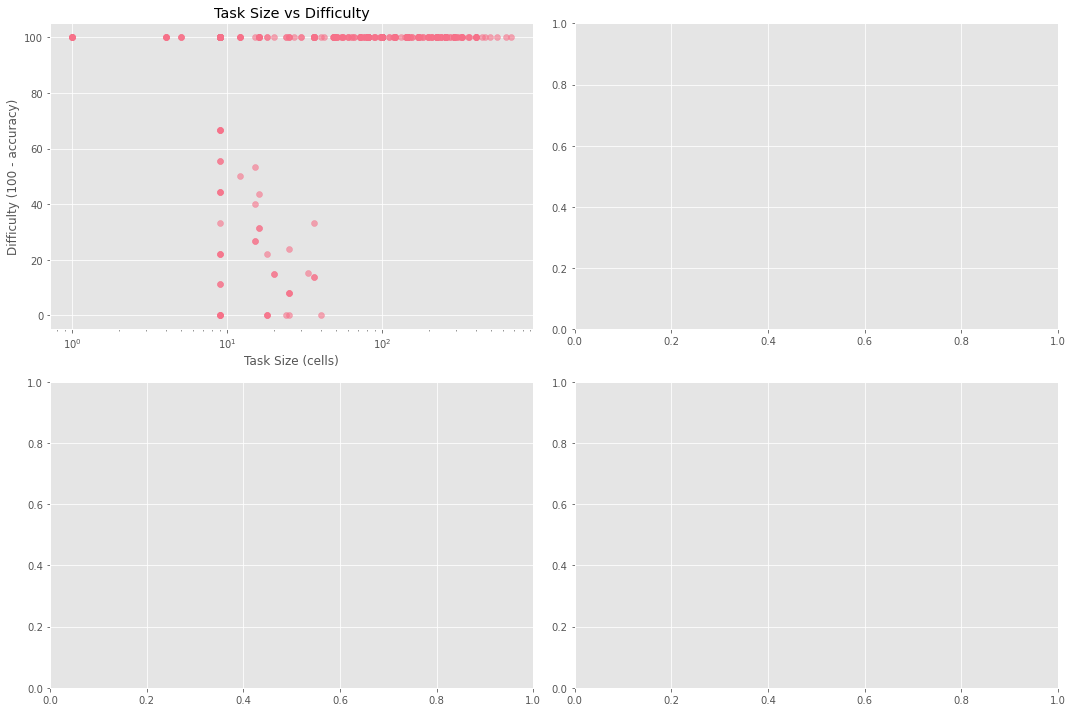

In [19]:
# Try to identify patterns that make tasks easier or harder
df_analysis = df[(~df['failed']) & (df['correct_size'].notna())].copy()

# Create difficulty score based on accuracy
df_analysis['difficulty'] = 100 - df_analysis['accuracy']

# Analyze factors contributing to difficulty
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Size vs difficulty
axes[0, 0].scatter(df_analysis['correct_size'], df_analysis['difficulty'], alpha=0.6)
axes[0, 0].set_xlabel('Task Size (cells)')
axes[0, 0].set_ylabel('Difficulty (100 - accuracy)')
axes[0, 0].set_title('Task Size vs Difficulty')
axes[0, 0].set_xscale('log')

# Aspect ratio vs difficulty
if 'correct_aspect' in df_analysis.columns:
    axes[0, 1].scatter(df_analysis['correct_aspect'], df_analysis['difficulty'], alpha=0.6)
    axes[0, 1].set_xlabel('Aspect Ratio')
    axes[0, 1].set_ylabel('Difficulty (100 - accuracy)')
    axes[0, 1].set_title('Aspect Ratio vs Difficulty')

# Size categories vs difficulty
if 'size_category' in df_analysis.columns:
    sns.boxplot(data=df_analysis, x='size_category', y='difficulty', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Size Category')
    axes[1, 0].set_ylabel('Difficulty (100 - accuracy)')
    axes[1, 0].set_title('Difficulty by Size Category')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Shape characteristics vs difficulty
if 'correct_is_square' in df_analysis.columns:
    square_difficulty = df_analysis.groupby('correct_is_square')['difficulty'].agg(['mean', 'count'])
    axes[1, 1].bar(['Non-square', 'Square'], square_difficulty['mean'])
    axes[1, 1].set_ylabel('Average Difficulty')
    axes[1, 1].set_title('Difficulty by Shape Type')
    for i, (count, mean) in enumerate(zip(square_difficulty['count'], square_difficulty['mean'])):
        axes[1, 1].text(i, mean + 1, f'n={count}', ha='center')

plt.tight_layout()
plt.show()

In [20]:
def analyze_task_patterns(df):
    """Analyze specific patterns in task performance."""
    
    results = {}
    
    # Perfect accuracy tasks
    perfect_tasks = df[df['accuracy'] == 100.0]
    results['perfect_count'] = len(perfect_tasks)
    
    if len(perfect_tasks) > 0:
        results['perfect_avg_size'] = perfect_tasks['correct_size'].mean()
        results['perfect_shape_match_rate'] = perfect_tasks['shape_match'].mean() if 'shape_match' in perfect_tasks else None
    
    # Zero accuracy tasks (excluding failed)
    zero_tasks = df[(df['accuracy'] == 0.0) & (~df['failed'])]
    results['zero_count'] = len(zero_tasks)
    
    if len(zero_tasks) > 0:
        results['zero_avg_size'] = zero_tasks['correct_size'].mean()
        results['zero_shape_match_rate'] = zero_tasks['shape_match'].mean() if 'shape_match' in zero_tasks else None
    
    # Size patterns
    if 'correct_size' in df.columns:
        size_quartiles = df['correct_size'].quantile([0.25, 0.5, 0.75])
        size_categories = pd.qcut(df['correct_size'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        
        acc_by_size_quartile = df.groupby(size_categories)['accuracy'].mean()
        results['accuracy_by_size_quartile'] = acc_by_size_quartile.to_dict()
    
    return results

# Run detailed analysis
analysis_results = analyze_task_patterns(df[~df['failed']])

print("Detailed Task Analysis:")
print("=" * 50)
print(f"Perfect accuracy tasks: {analysis_results['perfect_count']}")
if analysis_results['perfect_count'] > 0:
    print(f"  Average size: {analysis_results.get('perfect_avg_size', 'N/A'):.1f}")
    print(f"  Shape match rate: {analysis_results.get('perfect_shape_match_rate', 0) * 100:.1f}%")

print(f"\nZero accuracy tasks: {analysis_results['zero_count']}")
if analysis_results['zero_count'] > 0:
    print(f"  Average size: {analysis_results.get('zero_avg_size', 'N/A'):.1f}")
    print(f"  Shape match rate: {analysis_results.get('zero_shape_match_rate', 0) * 100:.1f}%")

print("\nAccuracy by size quartile:")
for quartile, acc in analysis_results.get('accuracy_by_size_quartile', {}).items():
    print(f"  {quartile}: {acc:.1f}%")

Detailed Task Analysis:
Perfect accuracy tasks: 11
  Average size: 17.1
  Shape match rate: 100.0%

Zero accuracy tasks: 327
  Average size: 123.9
  Shape match rate: 0.3%

Accuracy by size quartile:
  Q1: 30.2%
  Q2: 4.8%
  Q3: 0.0%
  Q4: 0.0%


In [21]:
def generate_summary_report(df, summaries):
    """Generate a comprehensive summary report."""
    
    print("LLaDA RESULTS ANALYSIS SUMMARY")
    print("=" * 50)
    
    # Overall statistics
    print("\n1. OVERALL STATISTICS")
    print("-" * 30)
    print(f"Total tasks analyzed: {len(df)}")
    print(f"Successful tasks: {len(df[~df['failed']])}")
    print(f"Failed tasks: {len(df[df['failed']])}")
    print(f"Average accuracy: {df[~df['failed']]['accuracy'].mean():.2f}%")
    print(f"Median accuracy: {df[~df['failed']]['accuracy'].median():.2f}%")
    print(f"Perfect accuracy (100%): {len(df[df['accuracy'] == 100.0])}")
    print(f"Zero accuracy (0%): {len(df[df['accuracy'] == 0.0])}")
    
    # Shape matching analysis
    if 'shape_match' in df.columns:
        shape_match_rate = df[~df['failed']]['shape_match'].mean()
        print("\n2. SHAPE MATCHING ANALYSIS")
        print("-" * 30)
        print(f"Shape match rate: {shape_match_rate * 100:.1f}%")
        
        shape_match_acc = df[~df['failed'] & df['shape_match']]['accuracy'].mean()
        shape_mismatch_acc = df[~df['failed'] & ~df['shape_match']]['accuracy'].mean()
        print(f"Average accuracy when shape matches: {shape_match_acc:.1f}%")
        print(f"Average accuracy when shape doesn't match: {shape_mismatch_acc:.1f}%")
    
    # Size analysis
    if 'correct_size' in df.columns:
        print("\n3. SIZE ANALYSIS")
        print("-" * 30)
        df_valid = df[~df['failed'] & df['correct_size'].notna()]
        print(f"Average task size: {df_valid['correct_size'].mean():.1f} cells")
        print(f"Median task size: {df_valid['correct_size'].median():.1f} cells")
        
        # Correlation between size and accuracy
        correlation = df_valid['correct_size'].corr(df_valid['accuracy'])
        print(f"Correlation between size and accuracy: {correlation:.3f}")
    
    # Error analysis
    print("\n4. ERROR ANALYSIS")
    print("-" * 30)
    error_types = df[df['failed']]['error_type'].value_counts()
    for error_type, count in error_types.items():
        print(f"{error_type}: {count}")
    
    # Key findings
    print("\n5. KEY FINDINGS")
    print("-" * 30)
    
    findings = []
    
    # Finding 1: Shape matching importance
    if 'shape_match' in df.columns:
        shape_match_acc = df[~df['failed'] & df['shape_match']]['accuracy'].mean()
        shape_mismatch_acc = df[~df['failed'] & ~df['shape_match']]['accuracy'].mean()
        if shape_match_acc > shape_mismatch_acc * 1.5:
            findings.append(f"Tasks with matching shapes perform significantly better ({shape_match_acc:.1f}% vs {shape_mismatch_acc:.1f}%)")
    
    # Finding 2: Size impact
    if 'correct_size' in df.columns:
        small_tasks = df[(~df['failed']) & (df['correct_size'] <= 25)]
        large_tasks = df[(~df['failed']) & (df['correct_size'] > 100)]
        if len(small_tasks) > 0 and len(large_tasks) > 0:
            small_acc = small_tasks['accuracy'].mean()
            large_acc = large_tasks['accuracy'].mean()
            if abs(small_acc - large_acc) > 10:
                better = "small" if small_acc > large_acc else "large"
                findings.append(f"{better.capitalize()} tasks perform better ({small_acc:.1f}% for small vs {large_acc:.1f}% for large)")
    
    # Finding 3: Perfect accuracy characteristics
    perfect_tasks = df[df['accuracy'] == 100.0]
    if len(perfect_tasks) > 5:
        avg_size = perfect_tasks['correct_size'].mean() if 'correct_size' in perfect_tasks else None
        if avg_size:
            findings.append(f"Perfect accuracy tasks have average size of {avg_size:.1f} cells")
    
    # Finding 4: Zero accuracy patterns
    zero_tasks = df[(df['accuracy'] == 0.0) & (~df['failed'])]
    if len(zero_tasks) > 10:
        if 'shape_match' in zero_tasks.columns:
            zero_shape_match = zero_tasks['shape_match'].mean()
            findings.append(f"Zero accuracy tasks have only {zero_shape_match * 100:.1f}% shape match rate")
    
    for i, finding in enumerate(findings, 1):
        print(f"{i}. {finding}")
    
    return findings

# Generate the summary report
generate_summary_report(df, summaries)

LLaDA RESULTS ANALYSIS SUMMARY

1. OVERALL STATISTICS
------------------------------
Total tasks analyzed: 372
Successful tasks: 372
Failed tasks: 0
Average accuracy: 9.11%
Median accuracy: 0.00%
Perfect accuracy (100%): 11
Zero accuracy (0%): 327

2. SHAPE MATCHING ANALYSIS
------------------------------
Shape match rate: 12.4%
Average accuracy when shape matches: 73.6%
Average accuracy when shape doesn't match: 0.0%

3. SIZE ANALYSIS
------------------------------
Average task size: 110.9 cells
Median task size: 90.0 cells
Correlation between size and accuracy: -0.303

4. ERROR ANALYSIS
------------------------------

5. KEY FINDINGS
------------------------------
1. Tasks with matching shapes perform significantly better (73.6% vs 0.0%)
2. Small tasks perform better (30.2% for small vs 0.0% for large)
3. Perfect accuracy tasks have average size of 17.1 cells
4. Zero accuracy tasks have only 0.3% shape match rate


['Tasks with matching shapes perform significantly better (73.6% vs 0.0%)',
 'Small tasks perform better (30.2% for small vs 0.0% for large)',
 'Perfect accuracy tasks have average size of 17.1 cells',
 'Zero accuracy tasks have only 0.3% shape match rate']

/state/partition1/job-60396494/ipykernel_2083602/1443440309.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter, ax=ax5)
/state/partition1/job-60396494/ipykernel_2083602/1443440309.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


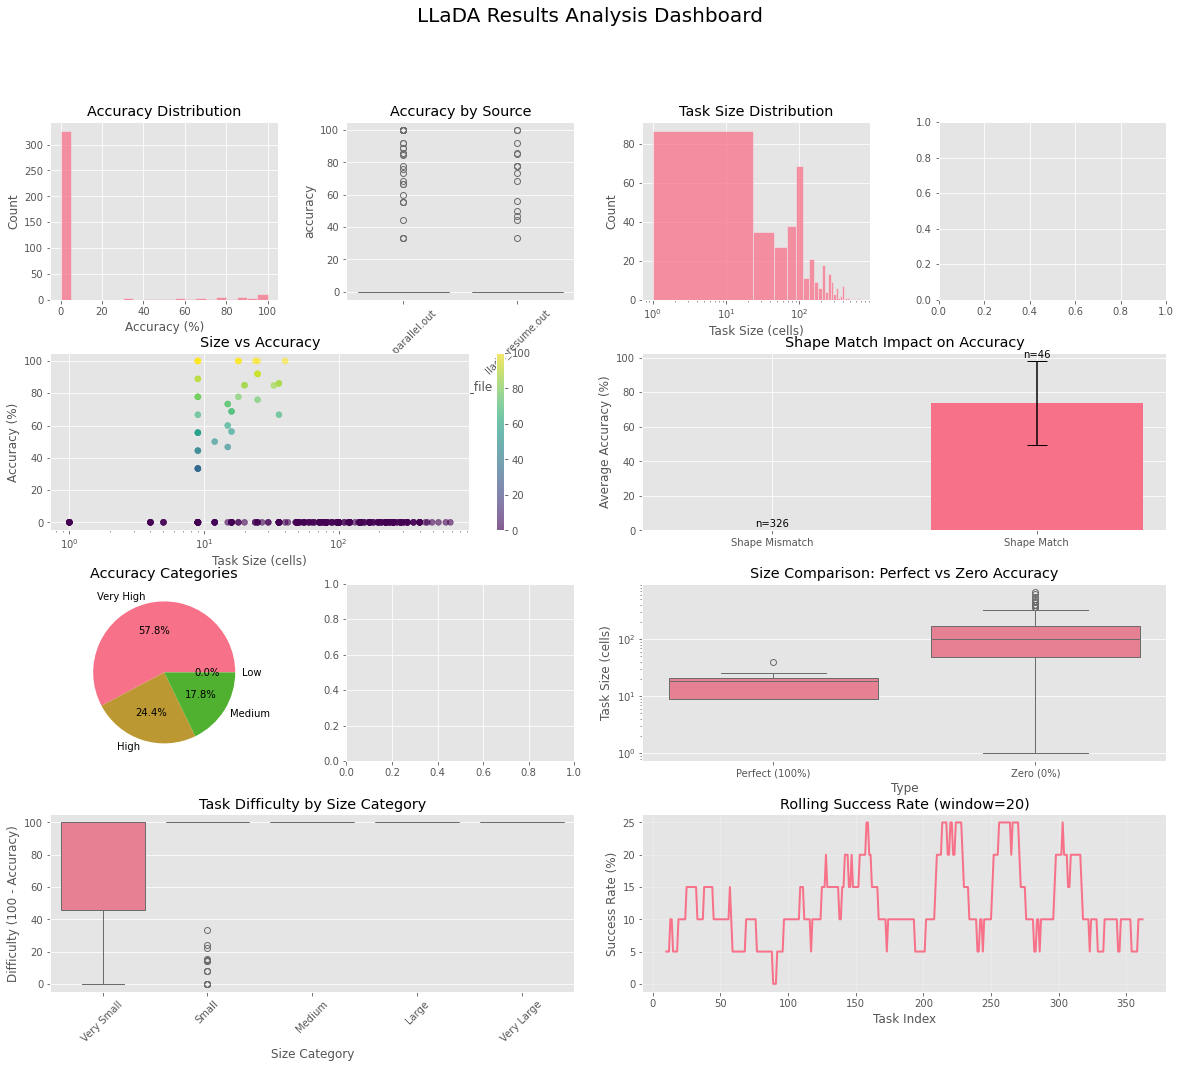

In [22]:
def create_dashboard(df):
    """Create a comprehensive visualization dashboard."""
    
    fig = plt.figure(figsize=(20, 16))
    
    # Create a grid layout
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # 1. Accuracy distribution
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(data=df[~df['failed']], x='accuracy', bins=20, ax=ax1)
    ax1.set_title('Accuracy Distribution')
    ax1.set_xlabel('Accuracy (%)')
    
    # 2. Accuracy by file source
    ax2 = fig.add_subplot(gs[0, 1])
    sns.boxplot(data=df[~df['failed']], x='source_file', y='accuracy', ax=ax2)
    ax2.set_title('Accuracy by Source')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Size distribution
    ax3 = fig.add_subplot(gs[0, 2])
    if 'correct_size' in df.columns:
        df_valid = df[~df['failed'] & df['correct_size'].notna()]
        sns.histplot(data=df_valid, x='correct_size', bins=30, ax=ax3)
        ax3.set_xlabel('Task Size (cells)')
        ax3.set_title('Task Size Distribution')
        ax3.set_xscale('log')
    
    # 4. Error types
    ax4 = fig.add_subplot(gs[0, 3])
    error_data = df[df['failed']]['error_type'].value_counts()
    if len(error_data) > 0:
        ax4.pie(error_data.values, labels=error_data.index, autopct='%1.1f%%')
        ax4.set_title('Error Types')
    
    # 5. Size vs Accuracy scatter
    ax5 = fig.add_subplot(gs[1, 0:2])
    if 'correct_size' in df.columns:
        df_valid = df[~df['failed'] & df['correct_size'].notna()]
        scatter = ax5.scatter(df_valid['correct_size'], df_valid['accuracy'], 
                             c=df_valid['accuracy'], cmap='viridis', alpha=0.6)
        ax5.set_xlabel('Task Size (cells)')
        ax5.set_ylabel('Accuracy (%)')
        ax5.set_title('Size vs Accuracy')
        ax5.set_xscale('log')
        plt.colorbar(scatter, ax=ax5)
    
    # 6. Shape match impact
    ax6 = fig.add_subplot(gs[1, 2:4])
    if 'shape_match' in df.columns:
        shape_data = df[~df['failed']].groupby('shape_match')['accuracy'].agg(['mean', 'std', 'count'])
        x = ['Shape Mismatch', 'Shape Match']
        y = shape_data['mean'].values
        err = shape_data['std'].values
        ax6.bar(x, y, yerr=err, capsize=10)
        ax6.set_ylabel('Average Accuracy (%)')
        ax6.set_title('Shape Match Impact on Accuracy')
        for i, (count, mean) in enumerate(zip(shape_data['count'], shape_data['mean'])):
            ax6.text(i, mean + err[i] + 2, f'n={count}', ha='center')
    
    # 7. Accuracy categories
    ax7 = fig.add_subplot(gs[2, 0])
    df_valid = df[~df['failed']]
    acc_cats = pd.cut(df_valid['accuracy'], 
                      bins=[0, 25, 50, 75, 100], 
                      labels=['Low', 'Medium', 'High', 'Very High'])
    acc_counts = acc_cats.value_counts()
    ax7.pie(acc_counts.values, labels=acc_counts.index, autopct='%1.1f%%')
    ax7.set_title('Accuracy Categories')
    
    # 8. Dimension match analysis
    ax8 = fig.add_subplot(gs[2, 1])
    if all(col in df.columns for col in ['correct_height', 'correct_width', 'generated_height', 'generated_width']):
        df_shape = df[~df['failed']].copy()
        df_shape['height_match'] = df_shape['correct_height'] == df_shape['generated_height']
        df_shape['width_match'] = df_shape['correct_width'] == df_shape['generated_width']
        
        dim_cats = []
        for _, row in df_shape.iterrows():
            if row['height_match'] and row['width_match']:
                dim_cats.append('Both')
            elif row['height_match']:
                dim_cats.append('Height')
            elif row['width_match']:
                dim_cats.append('Width')
            else:
                dim_cats.append('Neither')
        
        df_shape['dim_match'] = dim_cats
        sns.boxplot(data=df_shape, x='dim_match', y='accuracy', ax=ax8)
        ax8.set_xlabel('Dimension Match')
        ax8.set_ylabel('Accuracy (%)')
        ax8.set_title('Accuracy by Dimension Match')
    
    # 9. Perfect vs Zero accuracy comparison
    ax9 = fig.add_subplot(gs[2, 2:4])
    perfect = df[df['accuracy'] == 100.0]
    zero = df[(df['accuracy'] == 0.0) & (~df['failed'])]
    
    if len(perfect) > 0 and len(zero) > 0 and 'correct_size' in df.columns:
        data = []
        for task in perfect.itertuples():
            if pd.notna(task.correct_size):
                data.append(('Perfect (100%)', task.correct_size))
        for task in zero.itertuples():
            if pd.notna(task.correct_size):
                data.append(('Zero (0%)', task.correct_size))
        
        comp_df = pd.DataFrame(data, columns=['Type', 'Size'])
        sns.boxplot(data=comp_df, x='Type', y='Size', ax=ax9)
        ax9.set_ylabel('Task Size (cells)')
        ax9.set_title('Size Comparison: Perfect vs Zero Accuracy')
        ax9.set_yscale('log')
    
    # 10. Task difficulty by size category
    ax10 = fig.add_subplot(gs[3, 0:2])
    if 'correct_size' in df.columns:
        df_valid = df[~df['failed'] & df['correct_size'].notna()].copy()
        df_valid['size_category'] = pd.qcut(df_valid['correct_size'], 
                                          q=5, 
                                          labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])
        df_valid['difficulty'] = 100 - df_valid['accuracy']
        
        sns.boxplot(data=df_valid, x='size_category', y='difficulty', ax=ax10)
        ax10.set_xlabel('Size Category')
        ax10.set_ylabel('Difficulty (100 - Accuracy)')
        ax10.set_title('Task Difficulty by Size Category')
        ax10.tick_params(axis='x', rotation=45)
    
    # 11. Success rate timeline (if timestamps available)
    ax11 = fig.add_subplot(gs[3, 2:4])
    # Group by task index to show progress
    df_timeline = df.copy()
    df_timeline['task_index'] = range(len(df_timeline))
    df_timeline['success'] = ~df_timeline['failed'] & (df_timeline['accuracy'] > 0)
    
    # Calculate rolling success rate
    window_size = 20
    df_timeline['rolling_success'] = df_timeline['success'].rolling(window=window_size, center=True).mean() * 100
    
    ax11.plot(df_timeline['task_index'], df_timeline['rolling_success'], linewidth=2)
    ax11.set_xlabel('Task Index')
    ax11.set_ylabel('Success Rate (%)')
    ax11.set_title(f'Rolling Success Rate (window={window_size})')
    ax11.grid(True, alpha=0.3)
    
    plt.suptitle('LLaDA Results Analysis Dashboard', fontsize=20, y=0.98)
    plt.tight_layout()
    return fig

# Create the dashboard
dashboard_fig = create_dashboard(df)
plt.show()

In [23]:
# Save analysis results to CSV
analysis_df = df.copy()

# Add computed features
if all(col in analysis_df.columns for col in ['correct_size', 'generated_size']):
    analysis_df['size_diff'] = abs(analysis_df['correct_size'] - analysis_df['generated_size'])
    analysis_df['size_ratio'] = analysis_df['generated_size'] / analysis_df['correct_size']

if all(col in analysis_df.columns for col in ['correct_shape', 'generated_shape']):
    analysis_df['shape_match'] = analysis_df['correct_shape'] == analysis_df['generated_shape']

# Save to CSV
output_file = 'llada_analysis_results.csv'
analysis_df.to_csv(output_file, index=False)
print(f"Analysis results saved to {output_file}")

# Save summary statistics
summary_stats = {
    'total_tasks': len(df),
    'successful_tasks': len(df[~df['failed']]),
    'failed_tasks': len(df[df['failed']]),
    'average_accuracy': df[~df['failed']]['accuracy'].mean(),
    'median_accuracy': df[~df['failed']]['accuracy'].median(),
    'perfect_accuracy_count': len(df[df['accuracy'] == 100.0]),
    'zero_accuracy_count': len(df[df['accuracy'] == 0.0]),
}

if 'shape_match' in df.columns:
    summary_stats['shape_match_rate'] = df[~df['failed']]['shape_match'].mean()
    summary_stats['accuracy_with_shape_match'] = df[~df['failed'] & df['shape_match']]['accuracy'].mean()
    summary_stats['accuracy_without_shape_match'] = df[~df['failed'] & ~df['shape_match']]['accuracy'].mean()

# Save summary to JSON
with open('llada_summary_stats.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
print("Summary statistics saved to llada_summary_stats.json")

Analysis results saved to llada_analysis_results.csv
Summary statistics saved to llada_summary_stats.json


In [24]:
print("\nFINAL CONCLUSIONS")
print("=" * 50)

conclusions = []

# Conclusion 1: Overall performance
avg_acc = df[~df['failed']]['accuracy'].mean()
if avg_acc < 20:
    conclusions.append(f"The LLaDA model shows limited performance with an average accuracy of {avg_acc:.1f}%, suggesting significant room for improvement.")
elif avg_acc < 50:
    conclusions.append(f"The LLaDA model demonstrates moderate performance with an average accuracy of {avg_acc:.1f}%.")
else:
    conclusions.append(f"The LLaDA model performs well with an average accuracy of {avg_acc:.1f}%.")

# Conclusion 2: Shape matching importance
if 'shape_match' in df.columns:
    shape_impact = df[~df['failed'] & df['shape_match']]['accuracy'].mean() - df[~df['failed'] & ~df['shape_match']]['accuracy'].mean()
    if shape_impact > 20:
        conclusions.append(f"Shape matching is critical for success, with matched shapes having {shape_impact:.1f}% higher accuracy.")

# Conclusion 3: Size impact
if 'correct_size' in df.columns:
    size_correlation = df[~df['failed'] & df['correct_size'].notna()]['correct_size'].corr(df[~df['failed'] & df['correct_size'].notna()]['accuracy'])
    if abs(size_correlation) > 0.3:
        direction = "negatively" if size_correlation < 0 else "positively"
        conclusions.append(f"Task size {direction} correlates with accuracy (r={size_correlation:.3f}).")

# Conclusion 4: Error patterns
error_rate = df['failed'].mean() * 100
if error_rate > 5:
    conclusions.append(f"The model experiences a {error_rate:.1f}% failure rate, primarily due to memory issues.")

# Conclusion 5: Perfect accuracy insights
perfect_count = len(df[df['accuracy'] == 100.0])
total_tasks = len(df)
perfect_rate = perfect_count / total_tasks * 100
conclusions.append(f"Only {perfect_count} tasks ({perfect_rate:.1f}%) achieved perfect accuracy, indicating the model struggles with exact grid reproduction.")

for i, conclusion in enumerate(conclusions, 1):
    print(f"{i}. {conclusion}")
    
print("\nRecommendations for improvement:")
print("- Focus on improving shape matching mechanisms")
print("- Optimize memory usage for large tasks")
print("- Enhance grid size prediction accuracy")
print("- Investigate why most tasks achieve 0% accuracy")


FINAL CONCLUSIONS
1. The LLaDA model shows limited performance with an average accuracy of 9.1%, suggesting significant room for improvement.
2. Shape matching is critical for success, with matched shapes having 73.6% higher accuracy.
3. Task size negatively correlates with accuracy (r=-0.303).
4. Only 11 tasks (3.0%) achieved perfect accuracy, indicating the model struggles with exact grid reproduction.

Recommendations for improvement:
- Focus on improving shape matching mechanisms
- Optimize memory usage for large tasks
- Enhance grid size prediction accuracy
- Investigate why most tasks achieve 0% accuracy
